In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import logger_creator

import graph_tools
import graph_viz as viz
import networkx as nx
import numpy as np
import pandas as pd
import random

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [3]:
def generate_rmat_edge(N, A, B, C, D):
    """
    Recursively generate a single edge based on R-MAT quadrant probabilities.
    """
    src, dst = 0, 0
    step = N // 2
    while step > 0:
        p = random.random()
        if p < A:
            pass  # top-left quadrant
        elif p < A + B:
            dst += step  # top-right
        elif p < A + B + C:
            src += step  # bottom-left
        else:
            src += step
            dst += step  # bottom-right
        step //= 2
    return src, dst

def generate_rmat_multidigraph(N, M, A=0.45, B=0.15, C=0.15, D=0.25, seed=None):
    if seed is not None:
        random.seed(seed)

    G = nx.MultiDiGraph()
    G.add_nodes_from(range(N))

    for _ in range(M):
        src, dst = generate_rmat_edge(N, A, B, C, D)
        G.add_edge(src, dst)

    return G

def collapse_multiedges_to_weighted_digraph(multi_graph: nx.MultiDiGraph) -> nx.DiGraph:
    """
    Convert a MultiDiGraph to a DiGraph, summing the count of parallel edges
    into a 'weight' attribute for each edge.
    """
    digraph = nx.DiGraph()

    # Add nodes to the new graph (copy all node attributes)
    digraph.add_nodes_from(multi_graph.nodes(data=True))

    # Count edges and assign weight
    for u, v in multi_graph.edges():
        if digraph.has_edge(u, v):
            digraph[u][v]['weight'] += 1
        else:
            digraph.add_edge(u, v, weight=1)

    return digraph

def remove_low_weight_edges(G: nx.DiGraph, threshold: int = 2):
    """
    Removes all edges from G where the 'weight' attribute is less than the given threshold.
    This modifies G in-place.
    """
    edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if data.get("weight", 0) < threshold]
    G.remove_edges_from(edges_to_remove)


In [ ]:
# Parameters
N = 64  # Nodes (should be a power of 2 for "clean" R-MAT behavior)
M = N * 10  # Number of edges
A, B, C = 0.45, 0.15, 0.15
D = 1.0 - (A + B + C)

G = generate_rmat_multidigraph(N, M, A, B, C, D, seed=42)
G = collapse_multiedges_to_weighted_digraph(G)
remove_low_weight_edges(G, threshold=2)

print(f"Nodes: {G.number_of_nodes()}, Edges (including duplicates): {G.number_of_edges()}")

delegations = graph_tools.nx_graph_to_dict(G)

Nodes: 64, Edges (including duplicates): 183


In [101]:
#viz.visualize_delegation_graph(delegations)

# Benchmarking

In [12]:
range_x = [2 ** i for i in range(0, 10)]  # 2^0 to 2^4

time_data_le = []
time_data_lp = []
time_data_iterative = []

zero_indegree_counts = []
zero_outdegree_counts = []

logger, handler = logger_creator.create_logger("benchmarking")

times_le = []
times_lp = []
times_iterative = []

for num_nodes in range_x:
    print(num_nodes)

    countdown = 5
    while countdown > 0:
        countdown -= 1

        # Parameters
        N = num_nodes
        M = N * 10  # Number of edges
        A, B, C = 0.45, 0.15, 0.15
        D = 1.0 - (A + B + C)

        G = generate_rmat_multidigraph(N, M, A, B, C, D, seed=42)
        G = collapse_multiedges_to_weighted_digraph(G)
        remove_low_weight_edges(G, threshold=2)

        delegations = graph_tools.nx_graph_to_dict(G)

        delegation_graph = graph_tools.prepare_graph(G.nodes(), G.edges())
        delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
        delegations = graph_tools.invert_graph(delegations_orig)
        nodes = list(delegation_graph)

        try:
            lp_model = lp.set_up(delegations, nodes)
            _ = lp.resolve_delegations(delegations, nodes)
            break
        except:
            print(lp_model)
            SEED += 1
            print("Graph infeasible, retrying")

    # Collect in/out-degree statistics
    zero_indegree = sum(1 for node in G.nodes() if G.in_degree(node) == 0)
    zero_outdegree = sum(1 for node in G.nodes() if G.out_degree(node) == 0)
    zero_indegree_counts.append(zero_indegree)
    zero_outdegree_counts.append(zero_outdegree)

    # Verify the solutions are equal
    powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    powers_iter = iterative.iterate_delegations(delegations, nodes)

    if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-4 for k in powers_le):
        logger.error("Powers do not match")
        logger.error(f"LE: {powers_le}")
        logger.error(f"LP: {powers_lp}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
        break

    for node in sinks_le:
        if powers_lp[node] - powers_iter[node] < 0.01:
            continue
        else:
            logger.error("Powers do not match")
            logger.error(f"LP: {powers_lp}")
            logger.error(f"Iterative: {powers_iter}")
            print("Mismatching powers in LP and Iterative. Check the log file for details.")
            break

    n = 100  # You could still use your dynamic n logic if needed

    # LE
    le_model = le.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    times_le.append((end_time - start_time) / n)

    # LP
    lp_model = lp.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()
    times_lp.append((end_time - start_time) / n)

    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes)
    end_time = time.time()
    times_iterative.append((end_time - start_time) / n)

time_data_le.append(times_le)
time_data_lp.append(times_lp)
time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()


1
2
4
8
16
32
64
128
256
512


In [6]:
x = list(range_x)

print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

time_data_iterative
[[7.557868957519531e-05, 6.313085556030274e-05, 8.319854736328125e-05, 0.00020368337631225585, 0.00028682947158813475]]
time_data_le
[[2.1691322326660157e-05, 2.5250911712646484e-05, 2.26593017578125e-05, 2.2852420806884764e-05, 2.8417110443115234e-05]]
time_data_lp
[[0.02182171106338501, 0.02187483072280884, 0.02092345952987671, 0.021190390586853028, 0.022046842575073243]]


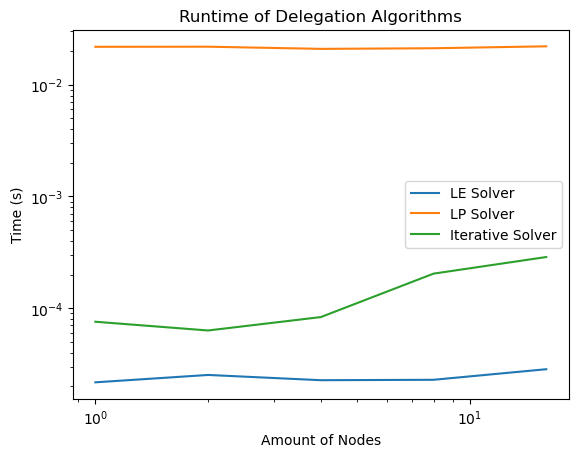

In [7]:
plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.loglog()
plt.show()